# Projecting playoff success - Measuring Parity

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})
plt.style.use('ggplot')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
#model = LogisticRegression(solver='liblinear', random_state=0)
# Or different approach
import numpy as np
import statsmodels.api as sm
# print result in latex
from stargazer.stargazer import Stargazer, LineLocation
from IPython.core.display import HTML

In [2]:
import os
cwd = os.getcwd()
cwd_git = os.path.dirname(os.path.dirname(os.path.dirname(cwd)))

import sys
sys.path.append(cwd_git)

import credentials
from credentials import cwd_data

#str_origin = "----- Your dir -----"
str_data = cwd_data + "nhl/data_gamelvl/data"


# import relevant functions
str_dir_sourceCode = cwd_git+"/NHL-Analytics/src/measurement"


# Pull all historical data

In [3]:
# Team box score
idx_yr_last = 2023
list_years = np.arange(2011, idx_yr_last)

# Pull regular season statistics of each team
df_reg = []
for iter in list_years:
    tempdf = pd.read_csv(str_data + f'/processed/{iter}_02_team.csv')
    # Track who is in the playoff
    tempdf_playoff = pd.read_csv(str_data + f'/processed/{iter}_03_possession_sequence.csv')
    series_teamInPlayoff = tempdf_playoff.team_home.unique()
    # Select only those in the playoff in the season
    tempdf = tempdf.loc[tempdf.team_tri_for.isin(series_teamInPlayoff), :]
    if iter == 2011:
        df = tempdf
    else:
        df = pd.concat([df, tempdf])

# Add the current season with filtered playoff teams
df_latest = pd.read_csv("2023_box_team_season_playoff.csv")
df = pd.concat([df, df_latest])

df_reg = df
df_reg.rename(columns = {"team_tri_for":"team_tri"}, inplace = True)


In [134]:
df_reg.columns

Index(['team_tri', 'fenwick_lvl', 'corsi_lvl', 'rpe', 'rwin', 'rgame', 'wp',
       'kpi_corsi', 'kpi_fenwick', 'kpi_pe', 'rwin_fittedPE', 'wp_own',
       'wp_ow', 'wp_oow', 'rpi', 'pairwise_win', 'kpi_pairwise', 'kpi_rpi',
       'kpi_wp', 'Final', 'idx_WinStreak', 'idx_WinStreak_expected',
       'idx_HotStreak', 'ratio', 'ratio_viz', 'yr_season'],
      dtype='object')

# Calculating Parity: Min-Max difference

In [4]:
# KPI to measure parity
#   Use discrete or continuous meausre, not ranks like Pairwise
idx_kpi = ['kpi_corsi', 'kpi_fenwick', 'kpi_pe', 'kpi_rpi']

In [5]:
# Min-max parity
parity_minmax = df_reg.groupby(['yr_season'])[idx_kpi].max() - df_reg.groupby(['yr_season'])[idx_kpi].min()
parity_minmax = parity_minmax / parity_minmax.loc[2011, :]
parity_minmax.columns = ["Corsi", "Fenwick", "Pythagorean", "RPI"]
# Std in parity
parity_stdvar = df_reg.groupby(['yr_season'])[idx_kpi].std()
parity_stdvar = parity_stdvar / parity_stdvar.loc[2011, :]
parity_stdvar.columns = ["Corsi", "Fenwick", "Pythagorean", "RPI"]

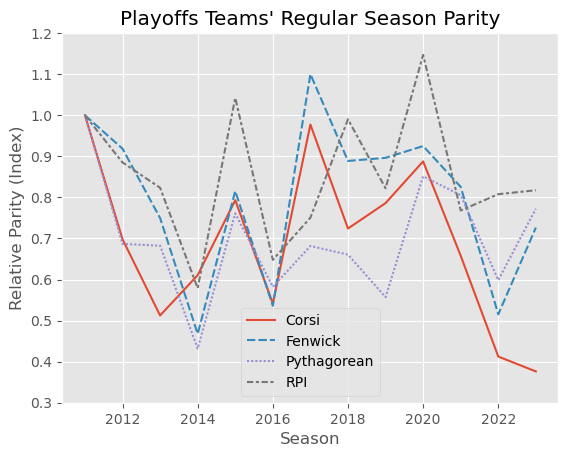

In [7]:
sns.lineplot(parity_stdvar)
plt.xlabel("Season")
plt.ylabel("Relative Parity (Index)")
plt.ylim([0.3, 1.2])
plt.title("Playoffs Teams' Regular Season Parity")

plt.savefig("./output/team_success_parity.png",  bbox_inches='tight', dpi=300)

# Measuring Parity by Calculating Number of Game 7's

In [46]:
# Pull regular season statistics of each team
df_playoff = []
for iter in list_years:
    tempdf = pd.read_csv(str_data + f'/cleaned/{iter}_03_box.csv')
    if iter == 2011:
        df = tempdf
    else:
        df = pd.concat([df, tempdf])
df_playoff = df

In [97]:
# Unique series indicator
df_playoff["series"] = [iter[:12] for iter in df_playoff.gameIdx]
# Season indicator based on regular season start year (-1)
df_playoff["season"] = [int(iter[-4:])-1 for iter in df_playoff["series"]]

# Calculate series count
df_series = df_playoff.groupby(["season", "series"]).gameIdx.count()/2
df_series = df_series.reset_index()
df_series["gameIdx"] = df_series["gameIdx"].astype(int)
df_series_hist = df_series.groupby(["season", "gameIdx"]).series.count().reset_index()

#df_series_hist = df_series_hist.pivot(columns="gameIdx", index="season", values="series")

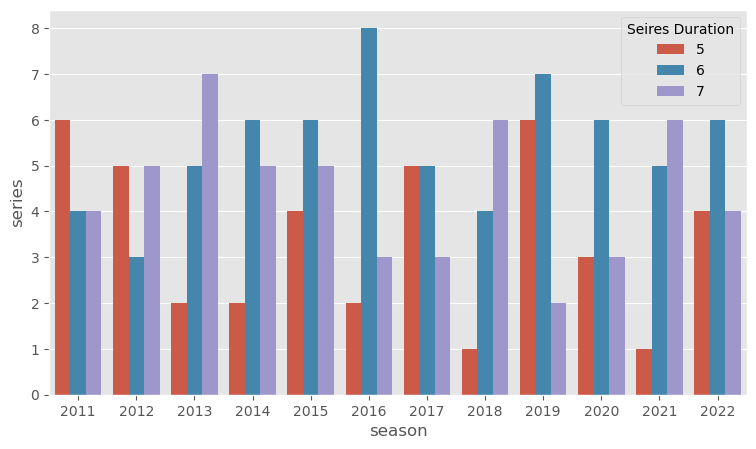

In [119]:
# Are there increasing number of game 6 & 7?
plt.figure(figsize=(9,5))
sns.barplot(df_series_hist.loc[df_series_hist["gameIdx"].isin([5,6,7])], x="season", y="series", hue="gameIdx")
plt.legend(title="Seires Duration")